In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import seaborn as sns
from random import randint
from main_data import (
    key_to_camelot,
    open_wheel,
    add_features,
    get_playlist,
    get_friendly,
    pickl,
    unpickl,
    sp,
)


In [ ]:
# %store -r streams_df streams_af_df no_skip_df playlist_af_df
# streams_df, streams_af_df, no_skip_df, playlist_af_df = streams_df, streams_af_df, no_skip_df, playlist_af_df


In [ ]:
# Import DataFrames generated by main_data.py
def import_all():
    global all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df
    (
        all_streams_df,
        streams_df,
        streams_af_df,
        no_skip_df,
        playlist_af_df,
        pod_df,
        wheel_df,
    ) = unpickl(
        "all_streams_df.p",
        "streams_df.p",
        "streams_af_df.p",
        "no_skip_df.p",
        "playlist_af_df.p",
        "podcasts_df.p",
        "wheel_df.p",
    )
    # return all_streams_df, streams_df, streams_af_df, no_skip_df, playlist_af_df, pod_df, wheel_df


In [ ]:
import_all()
all_streams_df

In [ ]:
# all_streams_df.loc[all_streams_df[all_streams_df.timestamp].dt.year == "2020"]
all_streams_df.timestamp.dt.year == 2020
# df["dtime"] = df[["timestamp"]].apply(lambda x: x.dt.time)

# dti = [all_streams_df.timestamp.reset_index(drop=True)]
all_streams_df.set_index(pd.DatetimeIndex(all_streams_df.ddate)).sort_index()


In [ ]:
all_streams_df.loc["2021", ""]


In [ ]:
# I don't recall listening to this artist so much. Investigating if it was on repeat on accident or something.

why_tala = streams_af_df.query('"Hope Tala" in artist')
why_why_tala = (
    why_tala.groupby(by="date")
    .sum(numeric_only=True)
    .sort_values(by="playtime", ascending=False)
)
why_why_tala["playtime"] = why_why_tala["playtime"].apply(lambda x: x / 60000)
why_why_tala.head(50)


In [ ]:
# Looks like I just let her run on most popular song repeat for a few hours.
streams_af_df.query('date == "11/27/2019"').sort_values(by="timestamp")


In [ ]:
no_skip_df.query('artist.str.contains("(?i)miles davis")', engine="python")


In [ ]:
def top_songs(years="all", skips=False, features=True):
    if skips and features:
        df = streams_af_df
    elif not skips:
        df = df.query("(playtime / duration) > 0.51").reset_index()


pivot_track = pd.DataFrame(
    no_skip_df.query('year == "2022"')
    .pivot_table(columns=["artist", "track", "year"], aggfunc="size")
    .sort_values(ascending=False)
)

pivot_track.head(30)


In [ ]:
no_skip_df.query('year == "2022"')


In [ ]:
# # Check for tracks missing from new df
# series1 = duration_prep['spotify_track_uri']
# series2 = local_features['uri']
# comparison = series1[~series1.isin(series2)]
# comparison


In [ ]:
# # Show missing track URLs for further investigation; track is likely removed or yet to be analyzed for audio_features.
# missing_tracks = []
# for i in range(len(comparison)):
#     missing_tracks.append(sp.track(comparison.iloc[i])['external_urls'])
# missing_tracks


In [ ]:
# Most played tracks
pivot_track = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist", "track"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_track


In [ ]:
# Most listened to artists by number of songs played
pivot_artist = pd.DataFrame(
    no_skip_df.pivot_table(columns=["artist"], aggfunc="size").sort_values(
        ascending=False
    )
)
pivot_artist


In [ ]:
no_skip_df


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime", ascending=False)
miles


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime", ascending=False)
pivot_album_time.head(20)


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime", ascending=False
).reset_index()
print(artist_time.to_string())


In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(streams_af_df["track"].unique())


In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime


In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should explore more of.
pivot_artist_time.query("playtime > 3600000").query("artist in @unique_export")


Todo: Next step after the above is to plot least uniques with most ms played

In [ ]:
# Convert
pivot_artist_time["playtime"] = pd.to_timedelta(pivot_artist_time.playtime, unit="ms")


In [ ]:
def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


In [ ]:
pivot_artist_time["playtime"] = pivot_artist_time["playtime"].apply(format_td)


In [ ]:
# Show longest songs
no_skip_df.sort_values(by="playtime", axis=0, ascending=False)


In [ ]:
# How to control this for missing months? do october 25 2019 thru 2022
sns_prep = streams_af_df.query('year == "2019"| year == "2020" | year == "2021"')
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime",
    index=["month"],
    aggfunc="sum",
).reset_index()
sns_prep["hours played"] = sns_prep["playtime"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x="month", y="hours played")


In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = streams_af_df.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = streams_af_df.copy().query("(playtime / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"].astype(str)
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


In [ ]:
# def show_transformations(df, song, transformation="all"):
#     song_key = df.query("(id == @song)")["camelot"]
#     # print(song_key)
#     keys = wheel_df.loc[transformation, song_key].reset_index(drop=True)
#     # print(type(keys))
#     print(keys[0])
#     return df.query("camelot.isin(@keys[0])", engine="python")


# fuck = show_transformations(streams_af_df, "115RufHm0zvrPN3MaheZ98", ["major"])
# fuck
# # song_key = playlist_af_df.loc[1, "camelot"]
# # friendkey = wheel_df.loc["dominant_relative", song_key]
# # playlist_af_df.query("camelot in @friendkey")


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    streams_af_df, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
streams_af_df.query("(playtime / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


In [ ]:
podcast_per_month = pod_df.groupby(by="month").sum(numeric_only=True)
sns.barplot(data=podcast_per_month, x=podcast_per_month, y=podcast_per_month.index)


In [12]:
pod_df


,timestamp,playtime,episode,show,spotify_episode_uri,start,end,ddate,dtime,date,time,month,year,day
0,2022-01-18 16:50:55+00:00,3141,178 – Joy of Cooking (Pies),Sleepy,spotify:episode:6Y7GtYpMqhGMkjp84Tbb2o,trackdone,trackdone,2022-01-18,16:50:55,01/18/2022,16:50:55,Jan,2022,Tue
1,2021-03-26 01:24:27+00:00,284,Episode 191: Suezter's Millions,Trillbilly Worker's Party,spotify:episode:6m2sPQxCjAs1ssW4HF3RZD,clickrow,endplay,2021-03-26,01:24:27,03/26/2021,01:24:27,Mar,2021,Fri
2,2022-08-31 18:31:16+00:00,3489,Part Three: Helena Blavatsky: the woman who in...,Behind the Bastards,spotify:episode:1mwh2W2ofPzGsFJRck4wx9,clickrow,trackdone,2022-08-31,18:31:16,08/31/2022,18:31:16,Aug,2022,Wed
3,2022-01-08 09:54:11+00:00,3579,Episode 231: Unexpected Truths,Trillbilly Worker's Party,spotify:episode:2poTejLxoGJ4OrydSteNnU,clickrow,trackdone,2022-01-08,09:54:11,01/08/2022,09:54:11,Jan,2022,Sat
4,2022-04-11 20:22:21+00:00,217,10.21- The Socialist Revolutionaries,Revolutions,spotify:episode:0BuHDMn2lR5Li257rXRcAV,clickrow,trackdone,2022-04-11,20:22:21,04/11/2022,20:22:21,Apr,2022,Mon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3841,2020-05-02 22:12:18+00:00,40,SUNDAY SERVICE 3: Great Political Leaders of t...,Trillbilly Worker's Party,spotify:episode:0sxM25cG9HLLCphvrbaFM3,trackdone,endplay,2020-05-02,22:12:18,05/02/2020,22:12:18,May,2020,Sat
3842,2022-01-10 05:23:40+00:00,3315,Charlie's Angels (2000),The Bechdel Cast,spotify:episode:5Es37WjDluqUKCCrdUfg25,clickrow,endplay,2022-01-10,05:23:40,01/10/2022,05:23:40,Jan,2022,Mon
3843,2021-03-02 03:06:40+00:00,3926,Groundhog Day with Jackie Kashian,The Bechdel Cast,spotify:episode:6q6BIbsO8AGbzPz4ijOZr9,trackdone,trackdone,2021-03-02,03:06:40,03/02/2021,03:06:40,Mar,2021,Tue
3844,2021-05-11 18:00:06+00:00,2392,Poetic Justice with Propaganda,The Bechdel Cast,spotify:episode:0CgOJkWW4Sgmq3EFllQDle,clickrow,endplay,2021-05-11,18:00:06,05/11/2021,18:00:06,May,2021,Tue


<AxesSubplot: xlabel='playtime', ylabel='month'>

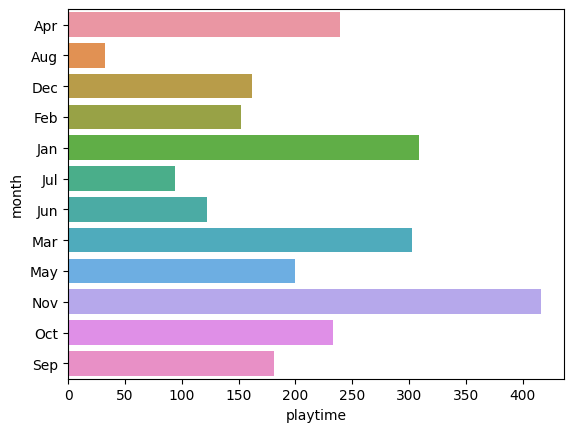

In [58]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats
podcasts_2020 = pod_df.copy()
podcasts_2020["playtime"] = podcasts_2020["playtime"].copy() / 3600
podcast_per_month = podcasts_2020.groupby(by="month").sum(numeric_only=True)
podcast_per_month["playtime"]
sns.barplot(
    data=podcast_per_month, x=podcast_per_month["playtime"], y=podcast_per_month.index
)


In [71]:
import_all()
pod = pod_df.copy()

In [74]:
# import_all()
pod = pod_df.copy()
pod.loc[:, 'hours'] = pod_df.loc[:, 'playtime'].copy() / 3600
pod.drop(columns=['spotify_episode_uri',
                            'start',
                           'playtime'])
pod.index = pod.timestamp
podm = pod.resample("M").sum().round()
podm
# podm.index.month

# pod.loc[:, "hours"] = pod_df.loc[:, "playtime"] / 3600
# pod.drop(columns=["spotify_episode_uri", "start", "playtime"])
# pod.index = pod.timestamp
# pod


# podm.index = podm.index.month
# podm


/tmp/ipykernel_31493/2674657645.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  podm = pod.resample("M").sum().round()


,playtime,hours
timestamp,,
2019-07-31 00:00:00+00:00,42,0.0
2019-08-31 00:00:00+00:00,16,0.0
2019-09-30 00:00:00+00:00,0,0.0
2019-10-31 00:00:00+00:00,0,0.0
2019-11-30 00:00:00+00:00,33182,0.0
2019-12-31 00:00:00+00:00,0,0.0
2020-01-31 00:00:00+00:00,2700,0.0
2020-02-29 00:00:00+00:00,0,0.0
2020-03-31 00:00:00+00:00,195574,0.0


In [ ]:
streams_af_df
